## Setup

In [59]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-cu9q_t75
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-cu9q_t75
  Resolved https://github.com/huggingface/transformers to commit bdee0889714e9cb3e53d3b1b2a626919479d356c
  Resolved https://github.com/huggingface/transformers to commit bdee0889714e9cb3e53d3b1b2a626919479d356c
  Installing build dependencies ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (pyproject.toml) ... done


In [60]:
from huggingface_hub import login
login()

In [61]:
!wget -O image.png "https://markomilenkovic.rs/random_media/lauzhack_2.png"

--2025-11-23 10:13:55--  https://markomilenkovic.rs/random_media/lauzhack_2.png
Resolving markomilenkovic.rs (markomilenkovic.rs)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to markomilenkovic.rs (markomilenkovic.rs)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2108126 (2.0M) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>]   2.01M  --.-KB/s    in 0.03s   

2025-11-23 10:13:55 (59.8 MB/s) - ‘image.png’ saved [2108126/2108126]



In [62]:
from pathlib import Path
from IPython.display import display
from PIL import Image


import matplotlib.pyplot as plt

p = "image.png"
image = Image.open("image.png")

# plt.imshow(image)
# plt.axis("off")
# plt.tight_layout()
# plt.show()

## Model

In [63]:
from transformers import Sam3Processor, Sam3Model
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def compute_orientation(mask, threshold=0.5):
    """
    Estimate orientation using PCA on mask pixels.
    Returns (angle_deg, centroid_xy, major_len, minor_len) or None if empty.
    angle_deg: degrees from image +x axis (right) positive CCW.
    centroid_xy: (x, y) in image coordinates.
    """
    if torch.is_tensor(mask):
        arr = mask.cpu().numpy()
    else:
        arr = np.array(mask)

    # normalize to boolean
    if arr.dtype == np.uint8 or arr.max() > 1:
        bw = arr > 127
    else:
        bw = arr > threshold

    coords = np.column_stack(np.where(bw))  # rows (y), cols (x)
    if coords.size == 0:
        return None

    centroid = coords.mean(axis=0)  # (y, x)
    centered = coords - centroid
    if centered.shape[0] < 2:
        return None

    cov = np.cov(centered, rowvar=False)  # 2x2 cov of [y, x]
    eigvals, eigvecs = np.linalg.eigh(cov)
    # largest eigenvalue -> principal axis
    idx = np.argmax(eigvals)
    major_vec = eigvecs[:, idx]  # [vy, vx]
    # convert to (vx, vy) and normalize
    vx, vy = float(major_vec[1]), float(major_vec[0])
    norm = np.hypot(vx, vy) or 1.0
    vx /= norm; vy /= norm

    angle_rad = np.arctan2(vy, vx)
    angle_deg = np.degrees(angle_rad)

    # approximate axis lengths from eigenvalues (scale factor arbitrary)
    major_len = 2.0 * np.sqrt(max(eigvals[idx], 0.0))
    minor_len = 2.0 * np.sqrt(max(eigvals[1-idx], 0.0))

    # centroid in (x, y)
    centroid_xy = (float(centroid[1]), float(centroid[0]))
    return angle_deg, centroid_xy, major_len, minor_len

def overlay_masks(image, masks, draw_orientations=True):
    image = image.convert("RGBA")
    masks_np = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks_np.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    orientations = []
    for mask, color in zip(masks_np, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

        # compute orientation for this mask
        orient = compute_orientation(mask)
        orientations.append((orient, color))

    if draw_orientations:
        draw = ImageDraw.Draw(image)
        for item in orientations:
            orient, color = item
            if orient is None:
                continue
            angle_deg, (cx, cy), major_len, minor_len = orient
            # draw a line for the major axis (scaled for visibility)
            L = max(20, major_len * 4)
            # direction vector
            ang = np.radians(angle_deg)
            dx = np.cos(ang) * L
            dy = np.sin(ang) * L
            # image coordinates: x right, y down (PIL uses same)
            start = (cx - dx, cy - dy)
            end = (cx + dx, cy + dy)
            draw.line([start, end], fill=(255,255,255,255), width=3)
            # small circle at centroid
            r = 4
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(255,255,255,255))

    return image, orientations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Detecting cars and and roads. Filtering cars by aspect ratio and their size.


Detecting cars and estimating their orientations...
Initially found 66 car objects. Filtering by aspect ratio and area...
Found 60 car objects after filtering
Filtered out 6 objects.


/tmp/ipython-input-159025772.py:120: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask_uint8, mode='L')


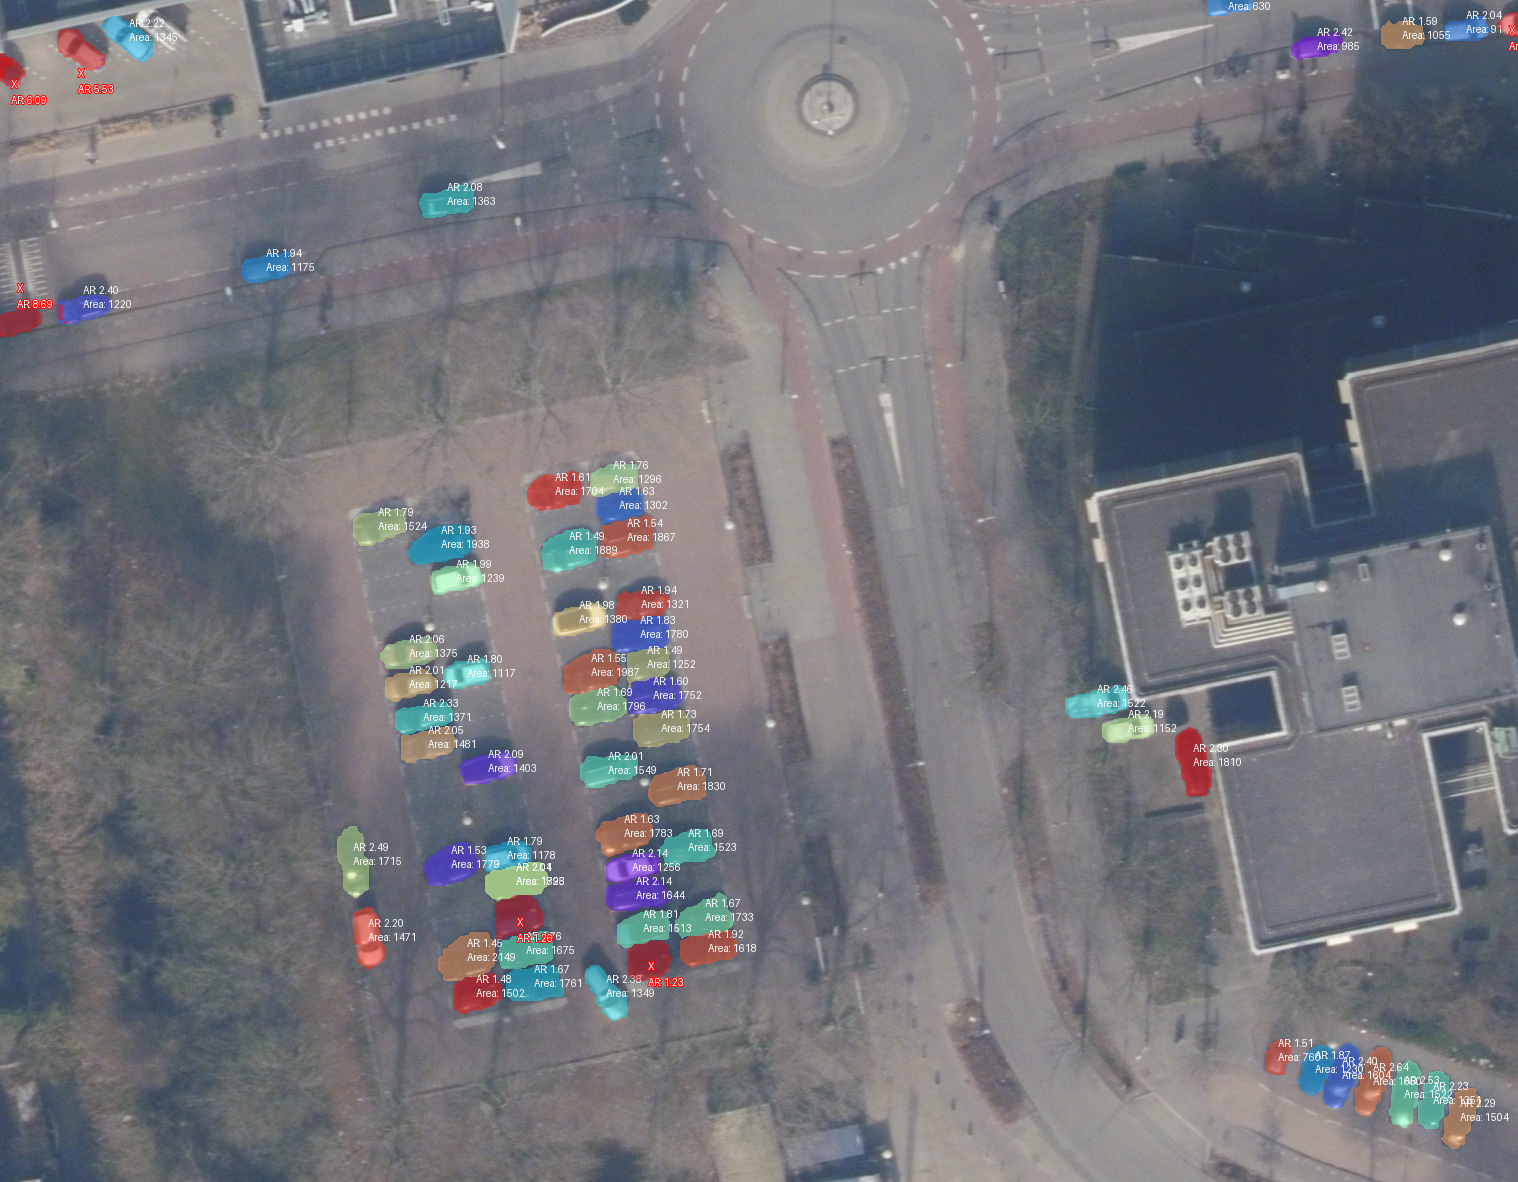

In [64]:
# detect cars and estimate orientations
from IPython.display import display
print("\nDetecting cars and estimating their orientations...")

inputs_cars = processor(images=image, text="car body", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_cars = model(**inputs_cars)

results_cars = processor.post_process_instance_segmentation(
    outputs_cars,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_cars.get("original_sizes").tolist()
)[0]

print(f"Initially found {len(results_cars['masks'])} car objects. Filtering by aspect ratio and area...")

# --- Filter by aspect ratio and area ---
VERBOSE = True # Toggle this to see filtered cars

keep_indices = []
min_aspect_ratio = 1.3
max_aspect_ratio = 3.8
min_area = 600  # Minimum area in pixels to be considered a car
max_area = 2800 # Maximum area in pixels to exclude trucks
filtered_info = [] # (index, reason)


all_masks = results_cars["masks"] # Keep reference to all masks

for i, mask in enumerate(all_masks):
    # Calculate area
    if torch.is_tensor(mask):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)
    
    # Check if mask is boolean or 0-1 or 0-255
    if mask_np.dtype == bool:
        area = np.sum(mask_np)
    else:
        area = np.sum(mask_np > 0)
        
    if area < min_area or area > max_area:
        filtered_info.append((i, f"Area: {area}"))
        continue

    orient = compute_orientation(mask)
    if orient is None:
        filtered_info.append((i, "No Orient"))
        continue
    _, _, major_len, minor_len = orient
    if minor_len < 1.0: # Avoid division by zero
        filtered_info.append((i, "Minor=0"))
        continue
    
    aspect_ratio = major_len / minor_len
    if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
        keep_indices.append(i)
    else:
        filtered_info.append((i, f"AR: {aspect_ratio:.2f}"))

# Apply filter
results_cars["masks"] = all_masks[keep_indices]
results_cars["scores"] = results_cars["scores"][keep_indices]
if "labels" in results_cars:
    results_cars["labels"] = results_cars["labels"][keep_indices]

print(f"Found {len(results_cars['masks'])} car objects after filtering")
if VERBOSE:
    print(f"Filtered out {len(filtered_info)} objects.")

cars_image, car_orientations = overlay_masks(image, results_cars["masks"], draw_orientations=False)
draw = ImageDraw.Draw(cars_image)

for i, (orient, _) in enumerate(car_orientations):
    if orient is None:
        pass
        # print(f"Car {i}: no mask pixels")
    else:
        # Calculate area for display
        mask = results_cars["masks"][i]
        if torch.is_tensor(mask):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = np.array(mask)
        
        if mask_np.dtype == bool:
            area = np.sum(mask_np)
        else:
            area = np.sum(mask_np > 0)

        angle_deg, centroid_xy, major_len, minor_len = orient
        # print(f"Car {i}: angle={angle_deg:.1f}°, centroid={centroid_xy}, major={major_len:.1f}, minor={minor_len:.1f}")
        
        if minor_len > 0:
            ar = major_len / minor_len
            # Draw aspect ratio and area above the centroid
            text = f"AR: {ar:.2f}\nArea: {area}"
            draw.text((centroid_xy[0], centroid_xy[1] - 20), text, fill="white")

# Draw filtered cars if VERBOSE
if VERBOSE:
    for idx, reason in filtered_info:
        mask = all_masks[idx]
        if torch.is_tensor(mask):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = np.array(mask)
        
        if mask_np.max() == 0: continue

        # Create red overlay for this mask
        # We want (255, 0, 0, 100) where mask is True
        overlay = Image.new("RGBA", cars_image.size, (255, 0, 0, 0)) # Red base
        
        # Create alpha mask: 100 where mask is True, 0 otherwise
        mask_uint8 = (mask_np > 0).astype(np.uint8) * 100
        mask_pil = Image.fromarray(mask_uint8, mode='L')
        
        overlay.putalpha(mask_pil) 
        
        cars_image = Image.alpha_composite(cars_image, overlay)
        
        # Draw text
        draw = ImageDraw.Draw(cars_image)
        
        ys, xs = np.where(mask_np > 0)
        if len(xs) > 0:
            cx, cy = xs.mean(), ys.mean()
            draw.text((cx, cy), f"X\n{reason}", fill="white", stroke_width=1, stroke_fill="red")

display(cars_image)

In [65]:
# --- roads detection (kept for visualization & filtering) --- #
print("\nDetecting roads...")

# prepare inputs for 'roads'
inputs_roads = processor(images=image, text="street road", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_roads = model(**inputs_roads)

results_roads = processor.post_process_instance_segmentation(
    outputs_roads,
    threshold=0.4,
    mask_threshold=0.55,
    target_sizes=inputs_roads.get("original_sizes").tolist()
)[0]

print(f"Found {len(results_roads['masks'])} road objects")

# road masks as numpy (H, W) bool
road_masks = results_roads["masks"]
if torch.is_tensor(road_masks):
    road_masks_np = road_masks.cpu().numpy().astype(bool)
else:
    road_masks_np = np.array(road_masks).astype(bool)

# Just overlay road masks (no angle logic)
road_image, road_orientations = overlay_masks(image, results_roads["masks"], draw_orientations=False)

### --- REMOVE CARS THAT ARE ON ROADS (SURROUNDED ON 4 SIDES) --- ###
print("\n=== Filtering out cars that are surrounded by road on all 4 sides ===")

car_masks = results_cars["masks"]
on_road_flags = []

# Build a single binary road mask
if road_masks_np.size == 0:
    union_road = None
    print("No road masks available, skipping road-based filtering.")
else:
    union_road = road_masks_np.any(axis=0)  # (H, W) bool

# How far from the centroid we look in each direction (in pixels)
surround_radius = 20  # tweak as needed

for i, mask in enumerate(car_masks):
    if torch.is_tensor(mask):
        car_mask_np = mask.cpu().numpy()
    else:
        car_mask_np = np.array(mask)

    # binarize car mask
    if car_mask_np.dtype == bool:
        car_bin = car_mask_np
    else:
        car_bin = car_mask_np > 0

    car_area = car_bin.sum()
    if car_area == 0 or union_road is None:
        # if no area or no roads, treat as off-road
        on_road_flags.append(False)
        continue

    # centroid from mask
    ys, xs = np.where(car_bin)
    cy = int(round(ys.mean()))
    cx = int(round(xs.mean()))

    # clamp to image bounds
    h, w = union_road.shape
    cy = max(0, min(h - 1, cy))
    cx = max(0, min(w - 1, cx))

    # Helper to test if along a ray from the centroid we hit road before we leave image
    def has_road_in_direction(dx, dy):
        for step in range(1, surround_radius + 1):
            yy = cy + dy * step
            xx = cx + dx * step
            if yy < 0 or yy >= h or xx < 0 or xx >= w:
                # Reached outside image before seeing road: not surrounded in this direction
                return False
            if union_road[yy, xx]:
                return True
        # Looked up to surround_radius without seeing road
        return False

    # Check all 4 directions: up, down, left, right
    up_has_road = has_road_in_direction(0, -1)
    down_has_road = has_road_in_direction(0, 1)
    left_has_road = has_road_in_direction(-1, 0)
    right_has_road = has_road_in_direction(1, 0)

    # Car is "on road" only if it's boxed-in by road on all 4 sides
    on_road = up_has_road and down_has_road and left_has_road and right_has_road
    on_road_flags.append(on_road)

n_on_road = sum(on_road_flags)
print(f"Cars surrounded by road (filtered out): {n_on_road}")
print(f"Cars off roads (kept for clustering): {len(on_road_flags) - n_on_road}")
### --- CLUSTER OFF-ROAD CARS INTO GROUPS AND VISUALIZE --- ###
print("\n=== Clustering OFF-ROAD cars into groups ===")

if len(car_orientations) == 0:
    print("No cars detected - cannot cluster.")
    clustered_image = cars_image.copy()
else:
    # collect centroids for off-road cars only
    offroad_centroids = []
    offroad_indices = []  # indices into car_orientations / results_cars

    for i, (orient, _) in enumerate(car_orientations):
        if on_road_flags[i]:
            continue  # skip cars that are on roads

        if orient is not None:
            _, centroid, _, _ = orient
            offroad_centroids.append(centroid)
            offroad_indices.append(i)
        else:
            # approximate centroid from mask if orientation is missing
            mask = results_cars["masks"][i]
            if torch.is_tensor(mask):
                mask_np = mask.cpu().numpy()
            else:
                mask_np = np.array(mask)
            ys, xs = np.where(mask_np > 0)
            if len(xs) == 0:
                continue
            offroad_centroids.append((float(xs.mean()), float(ys.mean())))
            offroad_indices.append(i)

    if len(offroad_centroids) == 0:
        print("No off-road cars to cluster.")
        clustered_image = cars_image.copy()
    else:
        offroad_centroids = np.array(offroad_centroids)

        # DBSCAN with permissive settings: every off-road car belongs to some cluster
        eps = 150  # pixels
        min_samples = 1  # this forces every point to belong to a cluster
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(offroad_centroids)
        labels = clustering.labels_

        unique_labels = sorted(set(labels))
        print(f"Total off-road cars: {len(offroad_centroids)}")
        print(f"Number of clusters (including singletons): {len(unique_labels)}")

        # create visualization image (start from original image)
        # also lightly show roads in the background
        roads_vis, _ = overlay_masks(image.copy(),  # use original image
                                    results_roads["masks"],
                                    draw_orientations=False)
        clustered_image = roads_vis.convert("RGBA")  # Convert back to RGBA!
        
        # Visualize filtered (on-road) cars if VERBOSE
        if 'VERBOSE' not in locals(): VERBOSE = True
        
        if VERBOSE:
             for i, is_on_road in enumerate(on_road_flags):
                 if is_on_road:
                     mask = results_cars["masks"][i]
                     if torch.is_tensor(mask):
                        mask_np = mask.cpu().numpy()
                     else:
                        mask_np = np.array(mask)
                     
                     if mask_np.max() == 0: continue

                     # Orange overlay for on-road cars
                     overlay = Image.new("RGBA", clustered_image.size, (255, 165, 0, 0)) # Orange
                     mask_uint8 = (mask_np > 0).astype(np.uint8) * 100
                     mask_pil = Image.fromarray(mask_uint8, mode='L')
                     overlay.putalpha(mask_pil)
                     clustered_image = Image.alpha_composite(clustered_image, overlay)
                     
                     # Text
                     draw = ImageDraw.Draw(clustered_image)
                     ys, xs = np.where(mask_np > 0)
                     if len(xs) > 0:
                        cx, cy = xs.mean(), ys.mean()
                        draw.text((cx, cy), "On Road", fill="white", stroke_width=1, stroke_fill="orange")

        draw = ImageDraw.Draw(clustered_image)

        # color palette for clusters
        base_colors = [
            (255, 0, 0),
            (0, 255, 0),
            (0, 0, 255),
            (255, 255, 0),
            (255, 0, 255),
            (0, 255, 255),
            (255, 128, 0),
            (128, 0, 255),
            (0, 128, 255),
            (128, 255, 0),
        ]

        from scipy.spatial import ConvexHull

        # Create a transparent overlay layer
        overlay = Image.new('RGBA', clustered_image.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        for lbl in unique_labels:
            # all off-road cars in this cluster
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            color = base_colors[lbl % len(base_colors)] if lbl != -1 else (200, 200, 200)

            # get centroids for this cluster
            cluster_points = offroad_centroids[idxs]
            
            # draw convex hull around cluster
            if len(cluster_points) >= 3:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points[hull.vertices]
                polygon = [tuple(point) for point in hull_points]
                overlay_draw.polygon(polygon, fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency
            elif len(cluster_points) == 2:
                p1, p2 = cluster_points
                padding = 20
                overlay_draw.line([tuple(p1), tuple(p2)], fill=color + (255,), width=3)
                for p in cluster_points:
                    overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                                outline=color + (255,), width=3)
            else:
                p = cluster_points[0]
                padding = 30
                overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                            fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency

        # Composite the overlay onto the base image
        clustered_image = Image.alpha_composite(clustered_image, overlay)
        draw = ImageDraw.Draw(clustered_image)

        # Now draw the cluster labels on top
        for lbl in unique_labels:
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            cluster_center = offroad_centroids[idxs].mean(axis=0)
            label_text = f"C{lbl if lbl >= 0 else 'N'} ({len(idxs)})"
            draw.text((cluster_center[0], cluster_center[1]),
                    label_text,
                    fill=(255, 255, 255, 255))

print("Clustering and visualization complete.")


Detecting roads...
Found 1 road objects

=== Filtering out cars that are surrounded by road on all 4 sides ===
Cars surrounded by road (filtered out): 0
Cars off roads (kept for clustering): 60

=== Clustering OFF-ROAD cars into groups ===
Total off-road cars: 60
Number of clusters (including singletons): 8
Clustering and visualization complete.


In [66]:
# plt.figure(figsize=(12, 6))
# plt.imshow(clustered_image)
# plt.axis("off")
# plt.title("Car clusters")
# plt.show()

In [67]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def get_obb_corners(center, width, height, angle_deg):
    """
    Calculate the 4 corners of an OBB.
    width: full width (along minor axis)
    height: full length (along major axis)
    """
    cx, cy = center
    theta = np.radians(angle_deg)
    
    # Vectors for half-width (dx) and half-height (dy)
    # Major axis is along 'angle', Minor is perpendicular
    
    # Major axis vector (half length)
    ux = np.cos(theta) * (height / 2)
    uy = np.sin(theta) * (height / 2)
    
    # Minor axis vector (half width) - perpendicular (-sin, cos)
    vx = -np.sin(theta) * (width / 2)
    vy = np.cos(theta) * (width / 2)
    
    # Corners: center +/- major +/- minor
    c1 = (cx + ux + vx, cy + uy + vy)
    c2 = (cx + ux - vx, cy + uy - vy)
    c3 = (cx - ux - vx, cy - uy - vy)
    c4 = (cx - ux + vx, cy - uy + vy)
    
    return [c1, c2, c3, c4]

def infer_parking_spaces(image, car_masks, car_orientations, offroad_indices, clustering_labels, road_mask_np=None, debug=False):
    """
    Infer parking spaces by checking around detected cars recursively.
    Constrained by the convex hull of the cluster.
    Filters out cars with orientation > 60 degrees from cluster mean.
    """
    h, w = image.size[1], image.size[0]
    
    def get_angle_diff(a, b):
        diff = abs(((a - b + 180) % 360) - 180)
        if diff > 90: diff = 180 - diff
        return diff

    # 1. Group cars by cluster
    clusters = {}
    for idx, label in zip(offroad_indices, clustering_labels):
        if label == -1: continue # Noise
        if label not in clusters: clusters[label] = []
        clusters[label].append(idx)
        
    parking_spots = [] # List of dicts: {'type': 'occupied'|'empty', 'corners': [...]}
    debug_candidates = []
    cluster_hulls = [] # Store polygons for visualization
    all_outliers = [] # Store outlier cars for visualization
    
    # Create a mask of all off-road cars for fast overlap checking
    all_cars_mask = np.zeros((h, w), dtype=np.uint8)
    for idx in offroad_indices:
        mask = car_masks[idx]
        if torch.is_tensor(mask): mask = mask.cpu().numpy()
        all_cars_mask = np.maximum(all_cars_mask, mask.astype(np.uint8))
        
    # Mask to keep track of inferred spots to prevent overlap
    inferred_spots_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. Process each cluster
    for label, indices in clusters.items():
        # First pass: collect all potential cars
        raw_cars = []
        angles = []
        
        for idx in indices:
            orient = car_orientations[idx][0] # (angle, center, major, minor)
            if orient is None: continue
            
            angle, center, major, minor = orient
            # PCA major/minor are approx half-lengths. 
            # Let's use a heuristic multiplier based on visual fit.
            l = major * 1.8
            wd = minor * 1.8
            
            raw_cars.append({'center': center, 'angle': angle, 'l': l, 'w': wd, 'idx': idx})
            angles.append(angle)
            
        if not raw_cars: continue
        
        # Calculate circular mean orientation for the cluster
        # Double angles to handle 180-degree ambiguity (axial data)
        angles_rad = np.radians(np.array(angles)) * 2
        mean_sin = np.mean(np.sin(angles_rad))
        mean_cos = np.mean(np.cos(angles_rad))
        mean_angle = np.degrees(np.arctan2(mean_sin, mean_cos) / 2)
        
        # Filter cars based on orientation
        cluster_cars = []
        cluster_points = []
        widths = []
        lengths = []
        all_cluster_corners = []
        
        for car in raw_cars:
            diff = get_angle_diff(car['angle'], mean_angle)
            if diff > 60:
                all_outliers.append(car)
                continue # Skip outlier
            
            cluster_cars.append(car)
            cluster_points.append(car['center'])
            widths.append(car['w'])
            lengths.append(car['l'])
            
            # Collect corners for hull (Lasso effect)
            corners = get_obb_corners(car['center'], car['w'], car['l'], car['angle'])
            all_cluster_corners.extend(corners)

        # Skip singleton clusters (after filtering)
        if len(cluster_cars) <= 2:
            continue
        
        avg_len = np.median(lengths)
        avg_width = np.median(widths)
        
        # Define search stride (width + small gap)
        step_dist = avg_width * 1.05 
        
        # Detect Row Axis (Minimum Area Rectangle) & Build Boundary
        cluster_path = None
        row_vector = None
        row_point = None
        
        if len(all_cluster_corners) >= 3:
            points = np.array(all_cluster_corners)
            try:
                hull = ConvexHull(points)
                hull_points = points[hull.vertices]
                
                # Use the Convex Hull of corners as the boundary (Lasso)
                cluster_path = Path(hull_points)
                cluster_hulls.append([tuple(p) for p in hull_points])
                
                min_area = float('inf')
                best_rect_params = None
                
                # Check each edge of the hull for MAR (Row Axis detection)
                num_v = len(hull_points)
                for i in range(num_v):
                    p1 = hull_points[i]
                    p2 = hull_points[(i + 1) % num_v]
                    
                    edge = p2 - p1
                    norm = np.linalg.norm(edge)
                    if norm < 1e-6: continue
                    
                    # Normalized edge vector (axis 1)
                    u = edge / norm
                    # Perpendicular vector (axis 2)
                    v = np.array([-u[1], u[0]])
                    
                    # Project all points onto axes
                    proj_u = np.dot(hull_points, u)
                    proj_v = np.dot(hull_points, v)
                    
                    min_u, max_u = np.min(proj_u), np.max(proj_u)
                    min_v, max_v = np.min(proj_v), np.max(proj_v)
                    
                    w_rect = max_u - min_u
                    h_rect = max_v - min_v
                    area = w_rect * h_rect
                    
                    if area < min_area:
                        min_area = area
                        best_rect_params = (u, v, min_u, max_u, min_v, max_v, w_rect, h_rect)
                
                if best_rect_params:
                    u, v, min_u, max_u, min_v, max_v, w_rect, h_rect = best_rect_params
                    
                    # Select the longer axis as the row vector
                    if w_rect > h_rect:
                        r_vec = u
                    else:
                        r_vec = v
                    
                    # Center of the rectangle
                    center_u = (min_u + max_u) / 2
                    center_v = (min_v + max_v) / 2
                    r_center = center_u * u + center_v * v
                    
                    car_rad = np.radians(mean_angle)
                    car_vec = np.array([np.cos(car_rad), np.sin(car_rad)])
                    dot = np.abs(np.dot(r_vec, car_vec))
                    
                    if dot < 0.8: # Side-by-side / Diagonal
                        row_vector = r_vec
                        row_point = r_center
                        sin_alpha = np.sqrt(1 - dot**2)
                        if sin_alpha > 0.1:
                            step_dist = (avg_width * 1.05) / sin_alpha
                            if step_dist > avg_len * 1.5: step_dist = avg_width * 1.05
            except Exception:
                pass 
        
        # Queue for BFS: (center, angle, width, length)
        queue = []
        visited_centers = [] # Keep track to avoid infinite loops locally
        
        # Initialize queue with existing cars
        for car in cluster_cars:
            queue.append(car)
            visited_centers.append(car['center'])
            
            # Add occupied spot (using average dimensions for uniformity)
            car_corners = get_obb_corners(car['center'], avg_width, avg_len, car['angle'])
            parking_spots.append({'type': 'occupied', 'corners': car_corners})

        # 3. Recursive Search (BFS)
        while queue:
            current_item = queue.pop(0)
            curr_center = current_item['center']
            curr_angle = current_item['angle']
            
            candidates = []
            if row_vector is not None:
                for sign in [1, -1]:
                    # Step along the row vector from the current center
                    step = row_vector * step_dist * sign
                    cand_center = np.array(curr_center) + step
                    candidates.append(tuple(cand_center))
            else:
                perp_angle = curr_angle + 90
                for direction in [1, -1]:
                    rad = np.radians(perp_angle)
                    dx = np.cos(rad) * step_dist * direction
                    dy = np.sin(rad) * step_dist * direction
                    candidates.append((curr_center[0] + dx, curr_center[1] + dy))

            for cand_center in candidates:
                
                if debug:
                    d_corners = get_obb_corners(cand_center, avg_width, avg_len, curr_angle)
                    debug_candidates.append(d_corners)

                # Check bounds
                cx, cy = cand_center
                if cx < 0 or cx >= w or cy < 0 or cy >= h: continue
                
                # CONSTRAINT: Check if inside Convex Hull
                if cluster_path:
                    if not cluster_path.contains_point(cand_center):
                        continue
                
                # Get candidate OBB corners
                cand_corners = get_obb_corners(cand_center, avg_width, avg_len, curr_angle)
                
                # Rasterize candidate for IoU check using PIL
                mask_img = Image.new('L', (w, h), 0)
                ImageDraw.Draw(mask_img).polygon(cand_corners, outline=1, fill=1)
                cand_mask = np.array(mask_img)
                
                cand_area = np.sum(cand_mask)
                if cand_area == 0: continue
                
                # Check overlap with existing cars
                overlap = np.sum(cand_mask & all_cars_mask)
                overlap_ratio = overlap / cand_area
                
                if overlap_ratio > 0.25:
                    # This spot is occupied by a car
                    # We don't add to queue because existing cars are already in queue
                    pass 
                else:
                    # Potential empty spot
                    # Check road overlap
                    if road_mask_np is not None:
                        # road_mask_np might be boolean
                        road_overlap = np.sum(cand_mask & road_mask_np.astype(np.uint8))
                        if (road_overlap / cand_area) > 0.2:
                            continue # On the road
                    
                    # Check overlap with already inferred spots (deduplication)
                    overlap_inferred = np.sum(cand_mask & inferred_spots_mask)
                    if (overlap_inferred / cand_area) > 0.25:
                        continue # Overlaps too much with another empty spot
                    
                    # Found a valid empty spot!
                    new_spot = {'type': 'empty', 'corners': cand_corners, 'center': cand_center, 'angle': curr_angle}
                    parking_spots.append(new_spot)
                    inferred_spots_mask = np.maximum(inferred_spots_mask, cand_mask)
                    
                    # Add to queue to continue search recursively
                    queue.append(new_spot)

    # 4. Visualization
    vis_image = image.copy().convert("RGBA")
    draw = ImageDraw.Draw(vis_image)

    if debug:
        for poly in debug_candidates:
            draw.polygon([tuple(p) for p in poly], outline=(0, 0, 255, 150), width=2)

        # Draw convex hulls for each cluster
        for poly in cluster_hulls:
            draw.polygon(poly, fill=(0, 255, 255, 30), outline=(0, 255, 255, 150))
            
        # Draw outliers
        for car in all_outliers:
             corners = get_obb_corners(car['center'], car['w'], car['l'], car['angle'])
             draw.polygon(corners, outline="magenta", width=2)
             draw.text(car['center'], "Outlier", fill="magenta")

    # Draw empty and occupied spots
    for spot in parking_spots:
        poly = [tuple(p) for p in spot['corners']]
        if spot['type'] == 'empty':
            # Draw green polygon
            draw.polygon(poly, fill=(0, 255, 0, 100), outline=(0, 255, 0, 255))
        elif spot['type'] == 'occupied':
            # Draw red polygon
            draw.polygon(poly, fill=(255, 0, 0, 100), outline=(255, 0, 0, 255))
            
    return vis_image, parking_spots

Inferring parking spaces...
Inferred 78 parking spots.


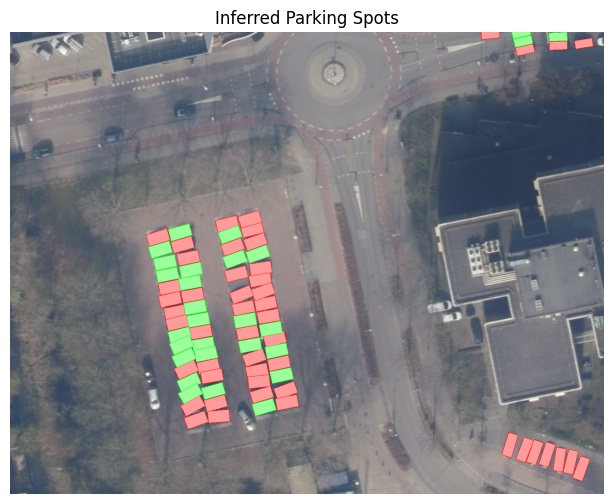

In [68]:
print("Inferring parking spaces...")

# Combine road masks into a single mask if available
if len(results_roads["masks"]) > 0:
    if torch.is_tensor(results_roads["masks"]):
        road_mask_combined = results_roads["masks"].any(dim=0).cpu().numpy()
    else:
        road_mask_combined = np.array(results_roads["masks"]).any(axis=0)
else:
    road_mask_combined = None

inferred_image, spots = infer_parking_spaces(
    image, 
    results_cars["masks"], 
    car_orientations, 
    offroad_indices, 
    labels, 
    road_mask_np=road_mask_combined,
    debug=False
)

print(f"Inferred {len(spots)} parking spots.")

plt.figure(figsize=(12, 6))
plt.imshow(inferred_image)
plt.axis("off")
plt.title("Inferred Parking Spots")
plt.show()

Downloading: lauzhack_2.png
Downloading: lauzhack_2_1.png
Downloading: lauzhack_2_2.png
Downloading: lauzhack_2_3.png
Downloading: lauzhack_2_4.png
Using 78 inferred parking spots as baseline
Total parking spots to analyze: 78
Year lauzhack_2.png: 58 cars detected
Year lauzhack_2_1.png: 33 cars detected
Year lauzhack_2_2.png: 31 cars detected
Year lauzhack_2_3.png: 84 cars detected
Year lauzhack_2_4.png: 9 cars detected


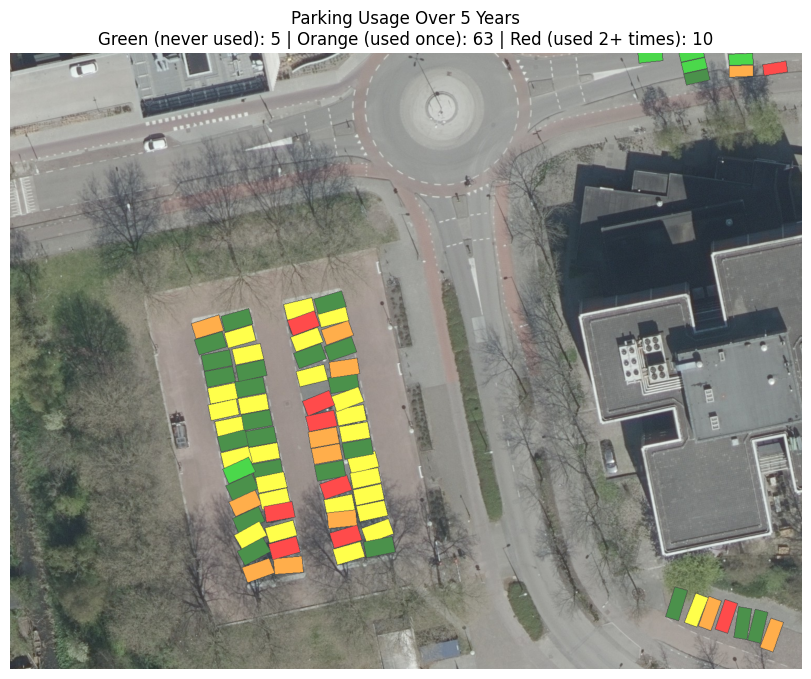


Summary:
Never used (Green): 5
Used once (Orange): 63
Frequently used (Red): 10
Total spots analyzed: 78


In [73]:
# --- Multi-year parking usage analysis using INFERRED parking spots ---
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import matplotlib.pyplot as plt

base_url = "https://markomilenkovic.rs/random_media"
years = [
    "lauzhack_2.png",
    "lauzhack_2_1.png",
    "lauzhack_2_2.png",
    "lauzhack_2_3.png",
    "lauzhack_2_4.png"
]

save_folder = "images_over_time"
os.makedirs(save_folder, exist_ok=True)

for filename in years:
    url = f"{base_url}/{filename}"
    save_path = f"{save_folder}/{filename}"
    print("Downloading:", filename)
    !wget -q -O "{save_path}" "{url}"

image_folder = "images_over_time"
image_paths = [os.path.join(image_folder, y) for y in years]

min_aspect_ratio = 1.3
max_aspect_ratio = 2.8
min_area = 800
max_area = 2500

# USE THE INFERRED SPOTS FROM THE FIRST ANALYSIS AS THE BASE
print(f"Using {len(spots)} inferred parking spots as baseline")

# Convert spots format - KEEP THE CORNERS DIRECTLY
parking_slots = []
for spot in spots:
    corners = spot['corners']
    corners_array = np.array(corners)
    center = tuple(corners_array.mean(axis=0))
    
    # Calculate dimensions from corners
    side1 = np.linalg.norm(corners_array[1] - corners_array[0])
    side2 = np.linalg.norm(corners_array[2] - corners_array[1])
    
    # Get angle from the spot directly if available
    if 'angle' in spot and spot['angle'] is not None:
        angle = spot['angle']
    else:
        # Calculate angle from the longer side
        vec1 = corners_array[1] - corners_array[0]
        vec2 = corners_array[2] - corners_array[1]
        
        # Use the longer vector for angle
        if np.linalg.norm(vec1) > np.linalg.norm(vec2):
            angle = np.degrees(np.arctan2(vec1[1], vec1[0]))
        else:
            angle = np.degrees(np.arctan2(vec2[1], vec2[0]))
    
    # Store corners directly along with metadata
    parking_slots.append({
        'corners': corners,
        'center': center,
        'width': min(side1, side2),
        'height': max(side1, side2),
        'angle': angle
    })

print(f"Total parking spots to analyze: {len(parking_slots)}")

# For each year, build a set of car centroids
car_centroids_per_year = []
for img_path in image_paths:
    image_year = Image.open(img_path)
    inputs_cars = processor(images=image_year, text="car body", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_cars = model(**inputs_cars)
    results_cars = processor.post_process_instance_segmentation(
        outputs_cars,
        threshold=0.5,
        mask_threshold=0.5,
        target_sizes=inputs_cars.get("original_sizes").tolist()
    )[0]
    
    centroids = []
    for i, mask in enumerate(results_cars["masks"]):
        mask_np = mask.cpu().numpy() if torch.is_tensor(mask) else np.array(mask)
        area = np.sum(mask_np > 0)
        if area < min_area or area > max_area:
            continue
        orient = compute_orientation(mask)
        if orient is None or len(orient) != 4:
            continue
        _, centroid, major, minor = orient
        if minor < 1.0:
            continue
        aspect_ratio = major / minor
        if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
            centroids.append(centroid)
    
    car_centroids_per_year.append(np.array(centroids) if len(centroids) > 0 else np.array([]))
    print(f"Year {os.path.basename(img_path)}: {len(centroids)} cars detected")

# Check if a point is inside a polygon (for accurate containment check)
def point_in_polygon(point, polygon):
    """Check if a point is inside a polygon using ray casting algorithm"""
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(1, n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside

# For each parking spot, count how many years a car centroid was inside
occupancy_count = np.zeros(len(parking_slots), dtype=int)
for i, slot in enumerate(parking_slots):
    for year_cents in car_centroids_per_year:
        if len(year_cents) == 0:
            continue
        # Check if any car centroid is inside this parking slot polygon
        inside = any(point_in_polygon(c, slot['corners']) for c in year_cents)
        if inside:
            occupancy_count[i] += 1

# Visualize on the latest image
latest_image = Image.open(image_paths[-1]).convert("RGBA")
draw = ImageDraw.Draw(latest_image)

green_count = 0
orange_count = 0
red_count = 0

for i, slot in enumerate(parking_slots):
    occ = occupancy_count[i]
    
    if occ == 0:
        color = (0, 200, 0, 180)  # Green (never used)
        green_count += 1
    elif occ == 1:
        color = (0, 100, 0, 180)  # Orange (used once)
        orange_count += 1
    elif occ == 2:
        color = (255, 255, 0, 180)  # Orange (used once)
        orange_count += 1
    elif occ == 3:
        color = (255, 140, 0, 180)  # Orange (used once)
        orange_count += 1
    else:
        color = (255, 0, 0, 180)  # Red (used 2+ times)
        red_count += 1
    
    # Draw using the original corners directly - NO RECALCULATION
    corners_tuple = [tuple(c) for c in slot['corners']]
    draw.polygon(corners_tuple, fill=color, outline=(0, 0, 0, 180))

plt.figure(figsize=(14, 8))
plt.imshow(latest_image)
plt.axis("off")
plt.title(f"Parking Usage Over {len(years)} Years\n"
          f"Green (never used): {green_count} | Orange (used once): {orange_count} | Red (used 2+ times): {red_count}")
plt.show()

print(f"\nSummary:")
print(f"Never used (Green): {green_count}")
print(f"Used once (Orange): {orange_count}")
print(f"Frequently used (Red): {red_count}")
print(f"Total spots analyzed: {len(parking_slots)}")